# <center> ASSIGNMENT 4  </center>
## <center>  Binary Classification using Linear and Kernel-Based Models</center>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
train_df = pd.read_csv(r".\datasets\dataset4.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

## Preprocessing

3680 921


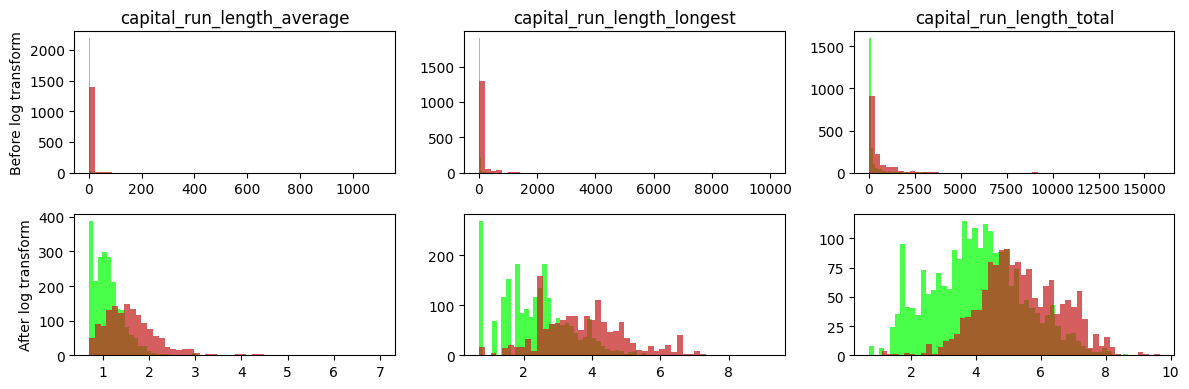

In [3]:
X = train_df.drop(["class"], axis=1)
y = train_df["class"]

X,X_test,y,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=2)
print(len(X), len(X_test))

fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,4))
i=0
axes = axes.flatten()
axes[0].set_ylabel("Before log transform")
axes[3].set_ylabel("After log transform")
for col in ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]:
    axes[i].hist(X[y==0][col],bins=50, color="#00ff00b6")
    axes[i].hist(X[y==1][col],bins=50, color="#c41f1fb6")
    axes[i].set_title(col)
    i+=1
for col in ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]:
    X[col] = X[col].apply(np.log1p)
    X_test[col] = X_test[col].apply(np.log1p)
for col in ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]:
    axes[i].hist(X[y==0][col],bins=50, color="#00ff00b6")
    axes[i].hist(X[y==1][col],bins=50, color="#c41f1fb6")
    i+=1

plt.tight_layout()
plt.savefig(f"latex/images/skew_analysis.pdf", bbox_inches='tight')
plt.show()

In [4]:

# Standardizing

scaler = StandardScaler()
scaler.set_output(transform="pandas")
X = scaler.fit_transform(X)

X_test = scaler.transform(X_test)


## EDA

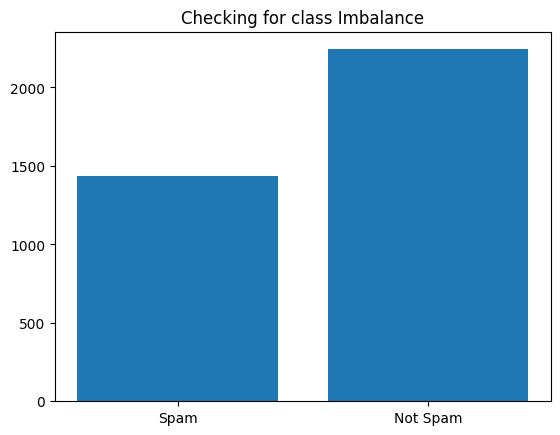

In [5]:
plt.bar(["Spam", "Not Spam"], [y[y==1].count(), y[y==0].count()])
plt.title("Checking for class Imbalance")
plt.savefig(f"latex/images/target_analysis.pdf", bbox_inches='tight')

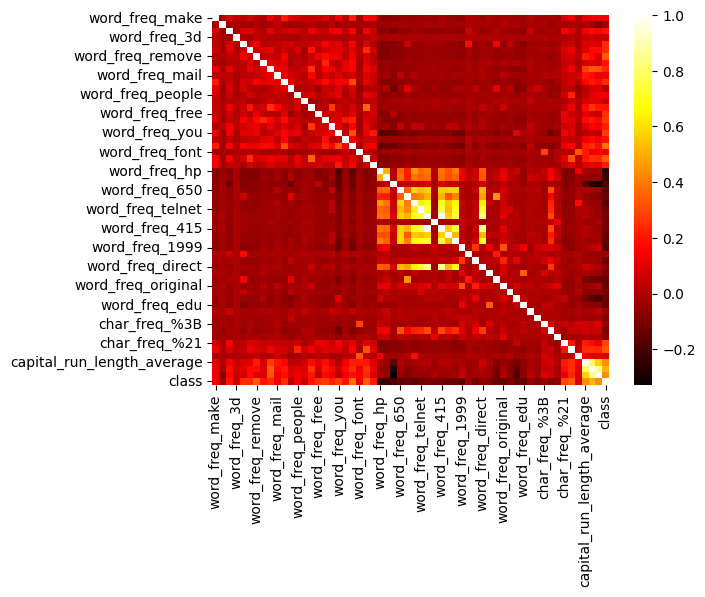

In [6]:
sns.heatmap(pd.concat([X,y], axis=1).corr(), cmap="hot")

plt.savefig(f"latex/images/heatmap.pdf", bbox_inches='tight')

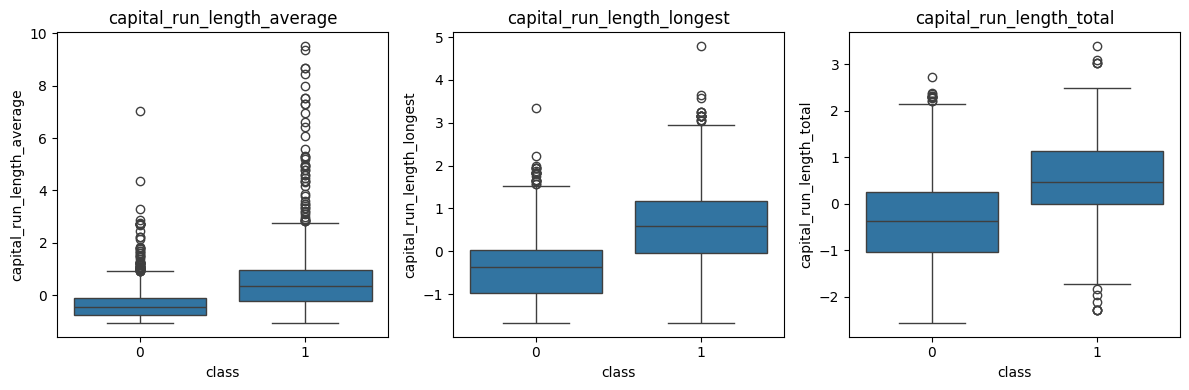

In [7]:
fig,axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4))
i=0
axes = axes.flatten()

for col in ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]:
    sns.boxplot(x=y,y=X[col],ax=axes[i])
    axes[i].set_title(col)
    i+=1

plt.tight_layout()
plt.savefig(f"latex/images/capital_run_analysis.pdf", bbox_inches='tight')
plt.show()

## Training baseline model

In [8]:
def evaluate(model,filename):
    model.fit(X,y)
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    print("Training time:", end-start)
    acc = accuracy_score(y_test,y_pred)
    prec= precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    f1  = f1_score(y_test,y_pred)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 score:", f1)

    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=axes[0])
    axes[0].set_title("CONFUSION MATRIX")
    RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
    axes[1].set_title("ROC CURVE")
    plt.tight_layout()
    plt.savefig(f"latex/images/{filename}.pdf", bbox_inches='tight')
    plt.show()
    

    
    

Training time: 0.0031871795654296875
Accuracy: 0.9391965255157437
Precision: 0.9444444444444444
Recall: 0.9042553191489362
F1 score: 0.9239130434782609


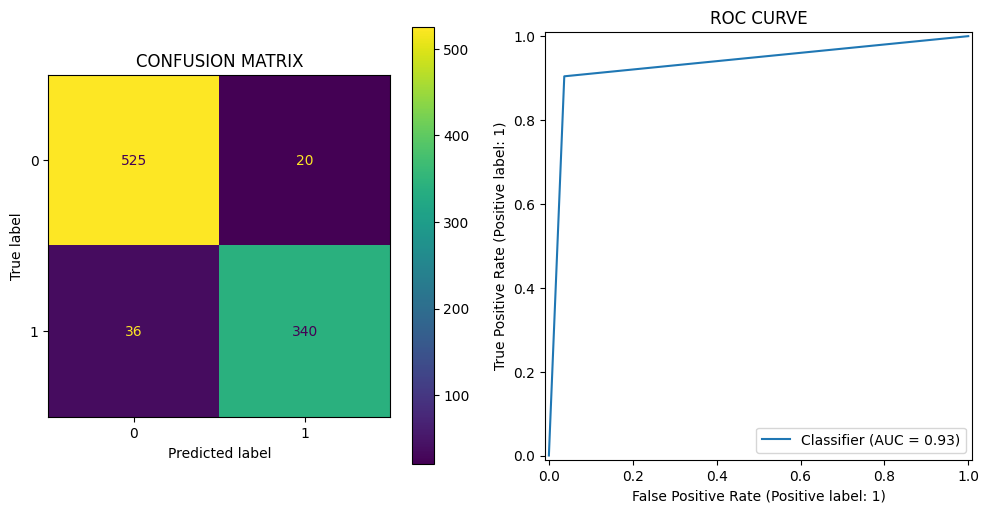

In [11]:

baseline = LogisticRegression()
evaluate(baseline, "baseline")


## Finetuning logistic regression

In [9]:
params = {
    "penalty": ["l1","l2"],
    "C": [0.01,0.1,1,10,100],
    "solver": ["liblinear","saga"]
}

kf = KFold(5, shuffle=True, random_state=2)

searcher = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)



{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'} 0.9117665217260786


Training time: 0.0020859241485595703
Accuracy: 0.9413680781758957
Precision: 0.9398907103825137
Recall: 0.9148936170212766
F1 score: 0.9272237196765498


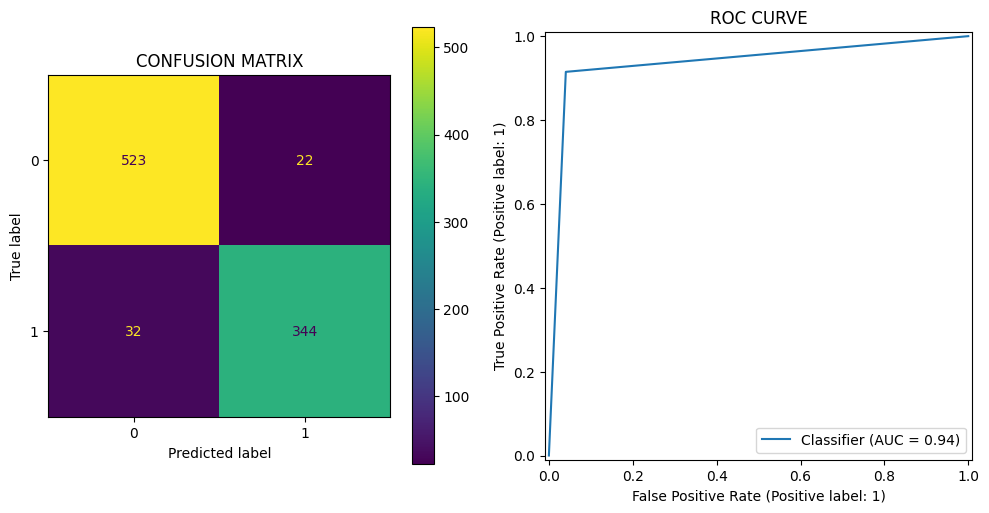

In [10]:
best_logreg = LogisticRegression(
    penalty="l2",
    C=100,
    solver="liblinear"
)

evaluate(best_logreg, "Logistic_Regression")

## Cross validation scores

In [12]:
cv_scores = cross_val_score(
    best_logreg,X,y,cv = KFold(5,shuffle=True,random_state=2)
)

print(cv_scores, cv_scores.mean())


[0.94565217 0.92119565 0.92934783 0.9375     0.92255435] 0.93125


## Linear SVC

In [18]:
params = {
    "kernel": ["linear"],
    "C": [0.1,1,10,100],
}

searcher = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)

{'C': 100, 'kernel': 'linear'} 0.9145946603719028


Training time: 0.02390265464782715
Accuracy: 0.9435396308360477
Precision: 0.9475138121546961
Recall: 0.9122340425531915
F1 score: 0.9295392953929539


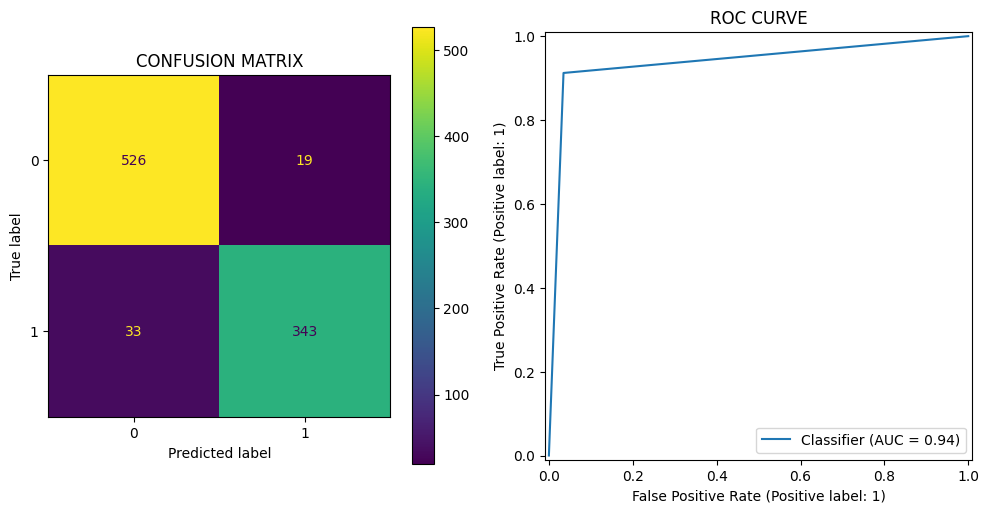

In [19]:
best_linear_svc = SVC(**searcher.best_params_)

evaluate(best_linear_svc, "Linear_SVC")

## Polynomial SVC

In [21]:
params = {
    "kernel": ["poly"],
    "C": [0.1,1,10,100],
    "degree": [2,3,4],
    "gamma": ["scale", "auto"]
}
searcher = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)

{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'} 0.8997852805323445


Training time: 0.04503464698791504
Accuracy: 0.9283387622149837
Precision: 0.9454022988505747
Recall: 0.875
F1 score: 0.9088397790055248


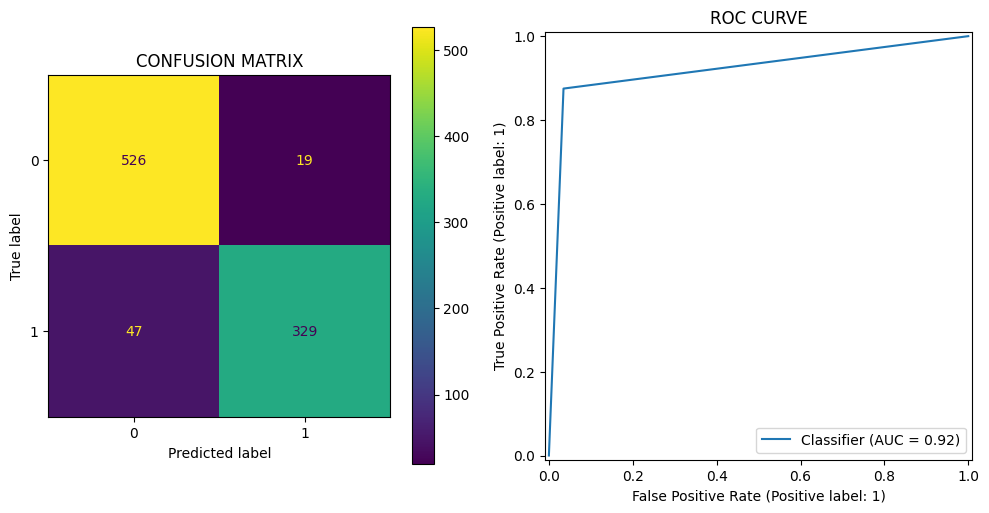

In [22]:
best_polynomial_svc = SVC(**searcher.best_params_)

evaluate(best_polynomial_svc, "Polynomial_SVC")

## Sigmoid SVC

In [23]:
params = {
    "kernel": ["sigmoid"],
    "C": [0.1,1,10,100],
    "gamma": ["scale", "auto"],
}

searcher = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)

{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'} 0.8790930781639041


Training time: 0.04795122146606445
Accuracy: 0.9001085776330076
Precision: 0.8901098901098901
Recall: 0.8617021276595744
F1 score: 0.8756756756756757


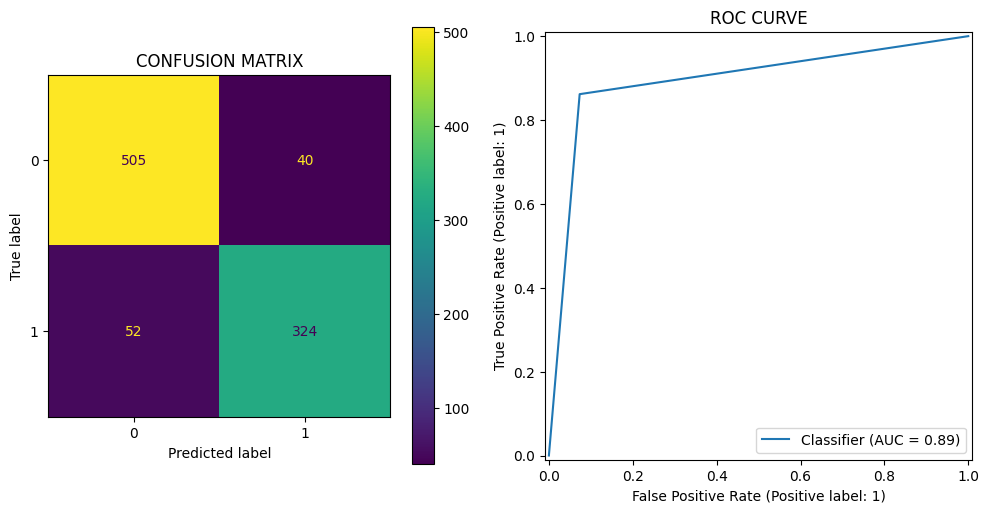

In [24]:
best_sigmoid_svc = SVC(**searcher.best_params_)

evaluate(best_sigmoid_svc, "Sigmoid_SVC")

## RBF SVC

In [25]:
params = {
    "kernel": ["rbf"],
    "C": [0.1,1,10,100],
    "gamma": ["scale", "auto"],
}

searcher = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 0.9182767037378567


Training time: 0.12222075462341309
Accuracy: 0.9359391965255157
Precision: 0.9439775910364145
Recall: 0.8962765957446809
F1 score: 0.9195088676671214


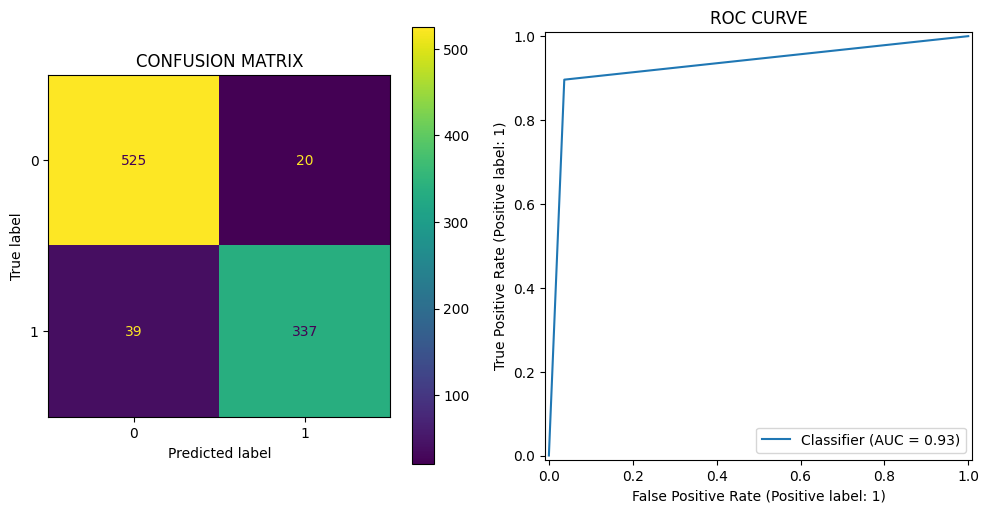

In [26]:
best_rbf_svc = SVC(**searcher.best_params_)

evaluate(best_rbf_svc, "RBF_SVC")

## Finetuning SVC

In [27]:
params = [
    {
        "kernel": ["linear"],
        "C": [0.1,1,10,100],
    },
    {
        "kernel": ["poly"],
        "C": [0.1,1,10,100],
        "gamma": ["scale", "auto"],
        "degree": [2,3,4]
    },
    {
        "kernel": ["rbf", "sigmoid"],
        "C": [0.1,1,10,100],
        "gamma": ["scale", "auto"],
    }
]

searcher = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="f1",
    cv = kf,
    n_jobs=-1
)

searcher.fit(X,y)

print(searcher.best_params_, searcher.best_score_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 0.9182767037378567


Training time: 0.11433720588684082
Accuracy: 0.9359391965255157
Precision: 0.9439775910364145
Recall: 0.8962765957446809
F1 score: 0.9195088676671214


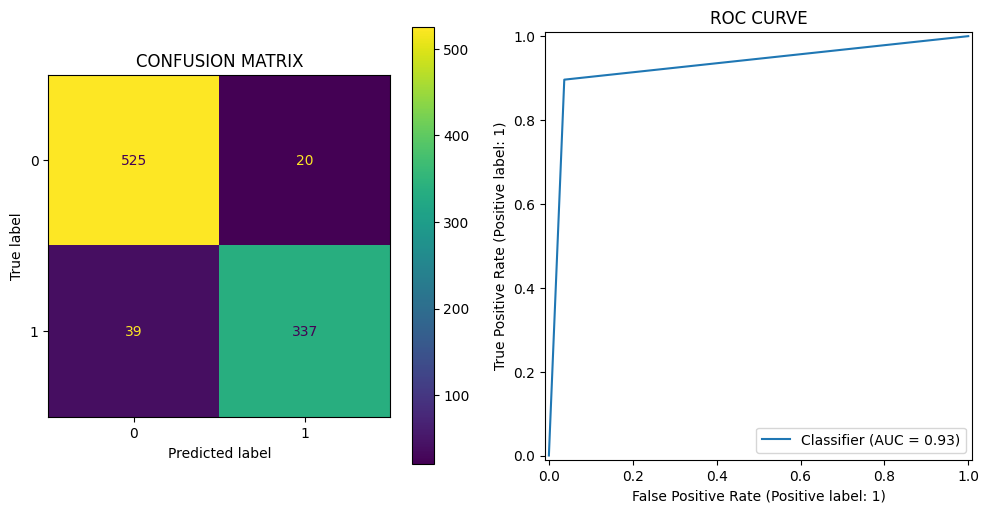

In [13]:
# best_svm = SVC(**searcher.best_params_)
best_svm = SVC(**{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})


evaluate(best_svm, "Best_SVM")


## Cross validation scores

In [14]:
cv_scores = cross_val_score(
    best_svm,X,y,cv = KFold(5,shuffle=True,random_state=2)
)

print(cv_scores, cv_scores.mean())


[0.94701087 0.92798913 0.9361413  0.93478261 0.94157609] 0.9375
